# Getting Started with Julia in Colab/Jupyter
You can either run this notebook in Google Colab, or using Jupyter on your own machine.

## Running on Google Colab

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.3" # any version ≥ 0.7.0
JULIA_PACKAGES="Knet AutoGrad IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia
  julia -e 'using Knet;'

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.5.3 on the current Colab Runtime...
2020-12-13 12:23:55 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz [105260711/105260711] -> "/tmp/julia.tar.gz" [1]
Installing Julia package Knet...
 Installing known registries into `~/.julia`
######################################################################## 100.0%
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed BFloat16s ──────────────────── v0.1.0
  Installed CodecZlib ──────────────────── v0.7.0
  Installed Compat ─────────────────────── v3.24.0
  Installed DataStructures ─────────────── v0.18.8
  Installed Requires ───────────────────── v1.1.1
  Installed GPUArrays ──────────────────── v6.1.2
  Installed FileIO ─────────────────────── v1.4.5
  Installed Reexport ───────────────────── v0.2.0
  Installed OpenSpecFun_jll ────────────── v0.5.3+4
  Installed TranscodingStreams ─────────── v0.9.5
  Installed ExprTools 

## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [2]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 4


# Your Own Work
Write your code under this section.


# Linear Regression on Housing Data
In the first lab assignment, you played with Boston Housing Dataset. In this lab assignment, you are going to implement a linear regression model trained on Boston Housing Data by using Knet for the first time. We will take advantage of iterators, callable objects and automatic differentation mechanism.

In [3]:
# Do not touch this cell
# Necessary imports
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick","ArgParse","CUDA"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
using Test
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Pkg.jl:554
   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
  Installed GLFW_jll ───────────────────── v3.3.2+1
  Installed SortingAlgorithms ──────────── v0.3.1
  Installed Qt_jll ─────────────────────── v5.15.2+0
  Installed Xorg_libX11_jll ────────────── v1.6.9+4
  Installed IteratorInterfaceExtensions ── v1.0.0
  Installed GeometryBasics ─────────────── v0.3.4
  Installed RecipesPipeline ────────────── v0.2.1
  Installed Plots ──────────────────────── v1.9.1
  Installed Libiconv_jll ───────────────── v1.16.0+7
  Installed Wayland_protocols_jll ──────

## Data Reading
You do not need to worry about data reading and preprocessing: We are going to take advantage of housing data reader which is also a part of Knet. We include some source file and then use ```housing``` function. ```housing``` function takes one input argument: the percentage of the test set to split dataset into two parts. Just take a look at the cell below. In this lab session, we are going to use 20% of the data as test split.

In [4]:
# Do not touch this cell
# Load data
include(joinpath(Knet.dir(), "examples", "housing-linreg", "housing.jl"))
Knet.seed!(1)
xtrn, ytrn, xtst, ytst = Housing.housing(0.20; url="https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data");

# Print size of data matrices for testing
size(xtrn), size(ytrn), size(xtst), size(ytst)

┌ Info: Precompiling ArgParse [c7e460c6-2fb9-53a9-8c5b-16f535851c63]
└ @ Base loading.jl:1278
┌ Warning: Knet.seed!() is deprecated, please use Random.seed!() and/or CUDA.seed!() instead
└ @ Knet.KnetArrays /root/.julia/packages/Knet/LdQyF/src/knetarrays/random.jl:15
┌ Info: Downloading https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data to /tmp/housing.data
└ @ Main.Housing /root/.julia/packages/Knet/LdQyF/examples/housing-linreg/housing.jl:59


((13, 405), (1, 405), (13, 101), (1, 101))

## Minibatching via Iterators
In this part, you are going implement a minibatching procedure (or let's call it pipeline). Remember, you need to implement your own minibatch function, it's forbidden to use Knet's ```minibatch``` procedure. Also, your minibatching scheme must use iterators. Just take a look at [this blog post](https://julialang.org/blog/2018/07/iterators-in-julia-0.7). To implement your minibatching pipeline, we provide you ```HousingData``` struct definition. Different from the original implementation, you are not going to discard the last remaining smaller minibatch, you will use all the instances. Also, remember that, ```HousingData``` structure is not mutable which means you are not able to change the values inside struct.

### Define `HousingData` Struct

In [5]:
"""
    HousingData(x, y; batchsize::Int=100, shuffle::Bool=false)

Create a HousingData object, where `x` is feature matrix, `y` is price array,
`batchsize` is number of instances in a minibatch and `shuffle` indicates
shuffling the order of the instances before the whole iteration process.
"""
struct HousingData
    x
    y
    batchsize::Int
    shuffle::Bool
    num_instances::Int

    function HousingData(
        x, y; batchsize::Int=100, shuffle::Bool=false, dtype::Type=Array{Float64})
        # Your code here, new(...)
        xsize = size(x)[end]
        return new(convert(dtype,x),convert(dtype,y), batchsize, shuffle, xsize)
    end
end

# tests for ```HousingData(x, y; ...)```
Knet.seed!(2)
x1 = randn(5, 100); y1 = rand(1, 100)
obj1 = HousingData(x1, y1; batchsize=20, dtype=Array{Float32}, shuffle=true)
@test obj1.shuffle == true
@test typeof(obj1.x) <: Array{Float32}
@test typeof(obj1.y) <: Array{Float32}
@test obj1.batchsize == 20
@test obj1.num_instances == 100
@test sum(abs2.(obj1.x - x1)) < 1e-6
@test sum(abs2.(obj1.y - y1)) < 1e-6
@info "constructor tests passed"

┌ Info: constructor tests passed
└ @ Main In[5]:34


### Implement `length` procedure.
Hint: You can use divrem function. Type ?divrem to see how to use.

In [6]:
HousingData

HousingData

In [7]:
"""
    length(d::HousingData)

Return how many minibatches dataset `d` has.
"""
function length(d::HousingData)
    # Your code here
    div= divrem(d.num_instances, d.batchsize, RoundUp)

    return div[1]
end

# tests for ```length(d::HousingData)```
Knet.seed!(3)
x1 = randn(5, 100); y1 = rand(1, 100)
test_helper1(batchsize) = HousingData(x1,y1; batchsize=batchsize)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
@test map(length, objects) == [5, 4, 2, 1, 1]
@info "length tests passed"

┌ Info: length tests passed
└ @ Main In[7]:19


### Implement `iterate` Procedure for `HousingData`
In this section, you'll finish your own iterator implementation by defining
`iterate` procedure for `HousingData` objects.

In [9]:
"""
    iterate(d::HousingData[, state])

Iterate over `d::HousingData` object. If `state` is missing, it's the beginning
of the whole iteration process.
"""
function iterate(d::HousingData, state=ifelse(
    d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    # Your code here

    n = length(state)
    n == 0 && return nothing
    bs = min(d.batchsize, n)
    i, new_state = state[1:bs], state[bs+1:end]
    x, y = d.x[:, i], d.y[:, i]

    return ((x,y), new_state)
end

Knet.seed!(4)
dtrn = HousingData(xtrn, ytrn; shuffle=true)
dtst = HousingData(xtst, ytst)

# Tests for ```iterate``` function
x1 = randn(5, 100); y1 = rand(1, 100);
test_helper2(batchsize) = HousingData(x1,y1; batchsize=batchsize)
test_helper3(batches) = mapreduce(bi->size(bi[2],2), +, batches)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
data_arrays = map(collect, objects)
num_instances = map(test_helper3, data_arrays)
@test map(length, data_arrays) == map(length, objects)
@test prod(num_instances .== 100) == 1
@info "iterate tests passed"

┌ Info: iterate tests passed
└ @ Main In[9]:33


## Model Implementation via Callable Objects
Next, we are going to implement our model via callable objects. In Julia, we can call objects. Just give a glimpse at the following code snippet:

In [10]:
struct Hello
    planet
    function Hello(planet="World")
        new(planet)
    end
end

(obj::Hello)() = println("Hello, $(obj.planet)!")

hello_world = Hello()
hello_world()

hello_jupiter = Hello("Jupiter")
hello_jupiter()

Hello, World!
Hello, Jupiter!


For this assingment, you just need to define a linear layer and that's all! Write your solutions to the below cell. Hint: You need to use ```Param``` method of AutoGrad. Just type ```@doc Param``` to see the documentation.

In [12]:
"""
    Linear(inputsize, outputsize; atype=Array{Float64}, scale::Float64=0.1)

Create a linear layer with its weight and bias. Initial weight parameters are
sampled from normal distribution scaled by a `scale` factor. Initial bias
values are zeros.

# Examples
```julia-repl
julia> layer = Linear(5,1);

julia> x = rand(2,5);

julia> layer(x); # forward call
```
"""
struct Linear # layer
    w
    b

    function Linear(inputsize::Int, outputsize::Int,
                    atype=Array{Float64}, scale::Float64=0.1)
        # Your code here
        x = inputsize
        y = outputsize
        return new(Param(convert(atype, scale * randn(y,x))), Param(convert(atype,zeros(y,1))))
    end
end


function (l::Linear)(x)
    # Your code here
    return l.w * x .+ l.b
end


model = Linear(13, 1)


# Tests for ```Linear```
Knet.seed!(5)
test_model = Linear(5,3)
test_data = rand(5,10)
@test fieldnames(Linear) == (:w, :b)
@test typeof(test_model.w) <: Param
@test typeof(test_model.b) <: Param
@test size(test_model.w) == (3,5)
@test size(test_model.b) == (3,1)
@test sum(abs2.(test_model.b.value)) ≈ 0.0
@test size(test_model(test_data)) == (3,10)
@info "Linear tests passed"

┌ Info: Linear tests passed
└ @ Main In[12]:51


## Define Loss Function
In this part, we'll define our loss function. We are going to use minimum squared error loss function,

![MSE](http://web.itu.edu.tr/keseni/mse.png)

We're going to define three diffent functions for this purpose,

1. A function takes predictions and target values as input.
2. A callable object procedure that takes input/output pair as input
3. A callable object procedure that takes our dataset object as input

See function prototypes below and the documentation of ```train!``` function.

In [13]:
"""
    mse(predicted, target)

Calculates minimum squared error (MSE) between predicted and target values.
"""
function mse(predictions, targets)
    # Your code here
    return sum(abs2.(predictions- targets))./(2*length(targets))
end


"""
    (m::Linear)(x, y)

Calculate MSE for a single minibatch by using a `Linear` layer / model.
"""
function (m::Linear)(x, y)
    # Your code here
    return mse(m(x),y)
end


"""
    (m::Linear)(data::HousingData)

Calculate MSE for the whole dataset by using a `Linear` layer / model.
"""
function (m::Linear)(data::HousingData)
    # Your code here
    return mean(m(x,y) for (x,y) in data)
end


# Tests for `mse`
Knet.seed!(6)
x1 = randn(5, 100); y1 = rand(1, 100); batchsize = 20
test_data = HousingData(x1,y1; batchsize=batchsize, shuffle=false)
test_model = Linear(5, 1)
bx, by = first(test_data)
batch_mse, data_mse = mse(test_model(bx), by), test_model(test_data)
data_mse = test_model(test_data)
@test batch_mse ≈ 0.17215155 || batch_mse ≈ 0.219498036
@test data_mse ≈ 0.21266383 || data_mse ≈ 0.215281964
@info "mse tests passed"

┌ Info: mse tests passed
└ @ Main In[13]:44


## Training with Modular Interface and Iterators
Now, let's implement a ```mytrain!``` procedure to train our network! It takes model, train data, test data, report period (in iterations) and number of maximum iterations. It trains our model until a certain maximum iterations number, records loss values of train and test data splits after each report period. It should output three lists: iterations numbers, loss values of train set, loss values of test set.

Hint: You may need ```sgd!```, ```cycle```, ```take``` and other similar procedures. Use default parameters for ```sgd!```.

┣████████████████████┫ [100.00%, 500/500, 00:02/00:02, 215.11i/s] 
┌ Info: mytrain! tests passed
└ @ Main In[14]:42


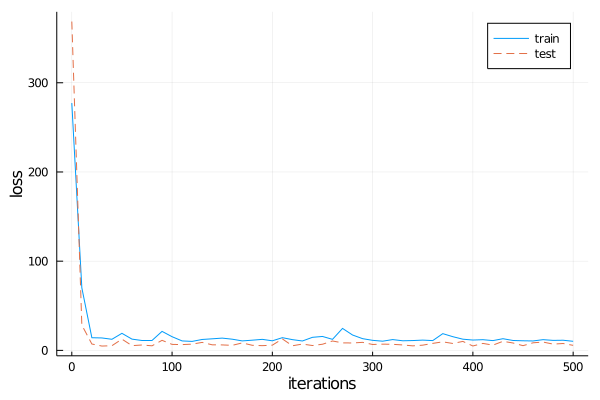

In [14]:
"""
    mytrain!(model::Linear, train_data::HousingData, test_data::HousingData, period=10, iters=500)

Train `model` on `train_data` for `iters` iterations. Calculate losses for the
whole train and test data splits (`train_data` and `test_data`) in every `period`
iteration. Return iteration numbers and losses for train and test data.
"""
function mytrain!(model::Linear, train_data::HousingData, test_data::HousingData,
                  period::Int=10, iters::Int=500)
    # Your code here

    updatedtrain = [] 
    updatedtest = []
    
    train_loss = Float64[model(train_data)]
    test_loss = Float64[model(test_data)]
    
    
    for (i, v) in enumerate(progress(sgd(model,take(cycle(train_data),iters))))
        if rem(i,period) == 0 
            updatedtrain =  model(train_data)
            push!(train_loss, updatedtrain)
            
            updatedtest =  model(test_data)
            push!(test_loss, updatedtest)
        end
        i > iters && break
    end

    return 0:period:iters, train_loss, test_loss
end


# Finally, let's train a network,
Knet.seed!(7)
model = Linear(13, 1)
dtrn = HousingData(xtrn, ytrn; shuffle=true)
dtst = HousingData(xtst, ytst)
iters, trnloss, tstloss = mytrain!(model, dtrn, dtst)
@test trnloss[2] ≈ 70.1396520
@test tstloss[2] ≈ 28.3967556
@info "mytrain! tests passed"
plot(iters, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(iters, tstloss, label="test")